To test the consistency of Gemini's translations and Parllaw's machine translations, we have to make sure their embeddings are comparable. 
For this test, a sample of which had been translated by Parllaw was tranlsated again by Gemini, to see: 

***a) Does Gemini regonize English speeches (and does not re-translate?)***

***b) Are Gemini's translations similar enough to Parrlaw's machine translations***


In [ ]:
import pandas as pd 
import langdetect
import numpy as np 
import os 

import preamble
from src.constants import EMBEDDING_MODEL, PATH_DF_TRANSLATION_TEST
from src.embeddings import get_model, embedd_texts

In [35]:
PATH_NON_MATCHED_TRANSLATIONS = "data/translation/df_translation_test_missmatches.parquet"

tested = pd.read_parquet(PATH_DF_TRANSLATION_TEST)
assert not tested["translatedText"].isna().any()

First: How many translations are exactly the same? => only consider disagreements between the translations

In [36]:
embedding_model = None 

def embedd_column(df, column_name, embedding_column_name):
    if embedding_column_name in df.columns: 
        print(embedding_column_name, "already computed")
    else: 
        global embedding_model
        if not embedding_model: 
            print("Loading model")
            # make sure model is only loaded once, and only if embeddings need to be computed 
            embedding_model = get_model(EMBEDDING_MODEL)

        embeddings = embedd_texts(embedding_model, df[column_name].tolist(), batch_size=1, show_progress_bar=True)
        df[embedding_column_name] = [x for x in embeddings]

In [37]:
if os.path.exists(PATH_NON_MATCHED_TRANSLATIONS): 
    non_matched = pd.read_parquet(PATH_NON_MATCHED_TRANSLATIONS)
else: 
    non_matched = tested[~(tested["translatedText"] == tested["translationTest"])].reset_index()

    embedd_column(non_matched, "text", "embeddings_og")
    embedd_column(non_matched, "translatedText", "embeddings_translated_pl")
    embedd_column(non_matched, "translationTest", "embeddings_translated_gm")

    non_matched.to_parquet(PATH_NON_MATCHED_TRANSLATIONS)
    

print("Verbatim matches:", len(tested) - len(non_matched), f"({(len(tested)-len(non_matched)) / len(tested)})")

Verbatim matches: 454 (0.227)


## a) Testing whether Gemini accurately detected English language

In [38]:
# using Google's langdetect as a baseline 
baseline_en = tested["text"].map(langdetect.detect) == "en"
gemini_en = tested["translationTestSource"] == "original_gm"
parllaw_en = tested["translationSource"] == "original_pl"

In [39]:
language_non_matched = sum(~(gemini_en == parllaw_en)) 
parllaw_correct = sum(baseline_en == parllaw_en)
gemini_correct = sum(baseline_en == gemini_en)

print("% disagreement parllaw and gemini", language_non_matched, f"({language_non_matched/ len(tested)})")
print("% correct parllaw", parllaw_correct, f"({parllaw_correct/ len(tested)})")
print("% correct gemini", gemini_correct, f"({gemini_correct/ len(tested)})")

% disagreement parllaw and gemini 391 (0.1955)
% correct parllaw 1984 (0.992)
% correct gemini 1607 (0.8035)


Hmm, thats not great... I looked at some examples where Gemini was wrong and it seems like it handled the cases where the original language was still included in a tag e.g. "(DE) this is the speech"

In [40]:
# false positives: 
print("Gemini false positives (eng when was not actually eng)", sum((gemini_en == True) & (baseline_en == False)) / len(tested))
print("Gemini false negatives (not eng when was not actually eng)", sum((gemini_en == False) & (baseline_en == True)), f"({sum((gemini_en == False) & (baseline_en == True)) / len(tested)})")

Gemini false positives (eng when was not actually eng) 0.0
Gemini false negatives (not eng when was not actually eng) 393 (0.1965)


Okay thats nice, so it only was too generous by re-translating text that was already in English. Confirming this by testing whether its mistakes were made primarily when the text was of a pattern "(XX) ...", indicating that the language tag XX was before the acutal speech

In [41]:
import re

pattern = re.compile(r"^\(.{2}\)\s")
contains_langflag = (tested["text"].map(lambda s: bool(pattern.match(s))))

print("N of those who did not start with (XX):")
print("Gemini english detection accuracy with language flag present:", sum(baseline_en[contains_langflag] == gemini_en[contains_langflag]) / len(baseline_en[contains_langflag]))
print("Gemini english detection accuracy without language flag present:", sum(baseline_en[~contains_langflag] == gemini_en[~contains_langflag]) / len(baseline_en[~contains_langflag]))

N of those who did not start with (XX):
Gemini english detection accuracy with language flag present: 0.3723916532905297
Gemini english detection accuracy without language flag present: 0.9985475671750181


Phew... So Gemini itself is reliable, we should have just removed the language tags before translating...

But why is it not 100% when there is no language flag? => look at the instances

In [42]:
gemini_ne_baseline_no_langflag = ~contains_langflag & ~(baseline_en == gemini_en)

tested[gemini_ne_baseline_no_langflag].join(
    baseline_en[gemini_ne_baseline_no_langflag].rename("baseline_eng")
).join(
    gemini_en[gemini_ne_baseline_no_langflag].rename("gemini_eng")
)[["text", "baseline_eng", "gemini_eng"]]

,text,baseline_eng,gemini_eng
1068,"A Uachtaráin, bhí an-díospóireacht againn agus...",True,False
1694,"Благодаря Ви, госпожо председател, и поздравле...",True,False


=> So these are (2 of 2000) instances where the baseline is actually wrong! 

## b) Comparing translation embeddings

In [43]:
import matplotlib.pyplot as plt
from scipy.stats import bootstrap, permutation_test
from scipy.spatial.distance import cosine

embedding_og = non_matched["embeddings_og"]
embedding_translated_pl = non_matched["embeddings_translated_pl"]
embedding_translated_gm = non_matched["embeddings_translated_gm"]
indices_english = non_matched["translationSource"] == "original_pl"

def sim(m1, m2):
    m1 = m1.tolist()
    m2 = m2.tolist()

    cos_dist = np.array([1 - cosine(m1[i], m2[i]) for i in range(len(m1))])
    return cos_dist

# first compute embedding similarity of texts that were in english already (but not matched word to word)
# - e.g. Gemini did not respond with "the text is in English" but repeated it verbatim and removed some comments:
similarity_eng_og_pl = sim(embedding_og[indices_english], embedding_translated_pl[indices_english])
similarity_eng_og_gm = sim(embedding_og[indices_english], embedding_translated_gm[indices_english])
similarity_eng_gm_pl = sim(embedding_translated_gm[indices_english], embedding_translated_pl[indices_english])

# sanity checks: quickly check metric seems correct 
# - similarity of vectors with themselves should be 1
# - similarity should be in range [-1, 1]
assert (sim(embedding_og[indices_english], embedding_og[indices_english]) == 1).all()
assert (sim(embedding_translated_gm[indices_english], embedding_translated_gm[indices_english]) == 1).all()
assert (sim(embedding_translated_pl[indices_english], embedding_translated_pl[indices_english]) == 1).all()
assert similarity_eng_og_pl.min() >= -1
assert similarity_eng_og_pl.max() <= 1

print("English texts: <= texts that where in English according to parllaw, but gemini's response was not the verbatim speech")
print("original ~ parllaw", similarity_eng_og_pl.mean(), f"(std: {'%.4f' % similarity_eng_og_pl.std()})")
print("original ~ gemini", similarity_eng_og_gm.mean(), f"(std: {'%.4f' % similarity_eng_og_gm.std()})")
print("gemini ~ parllaw", similarity_eng_gm_pl.mean(), f"(std: {'%.4f' % similarity_eng_gm_pl.std()})")


English texts: <= texts that where in English according to parllaw, but gemini's response was not the verbatim speech
original ~ parllaw 0.9983505 (std: 0.0029)
original ~ gemini 0.9915527 (std: 0.0097)
gemini ~ parllaw 0.9916396 (std: 0.0088)


For the instances where Gemini (and Parllaw also) re-translated texts that were already in English (according to Google's langdetect), the resulting translations are almost the same as the original text in the embedding space. 

=> We assume that the re-translation therefore did not significantly influence the speech

In [44]:
# now similarity of non-english texts:
similarity_non_eng_og_pl = sim(embedding_og[~indices_english], embedding_translated_pl[~indices_english])
similarity_non_eng_og_gm = sim(embedding_og[~indices_english], embedding_translated_gm[~indices_english])
similarity_non_eng_gm_pl = sim(embedding_translated_gm[~indices_english], embedding_translated_pl[~indices_english])

print("\nNon-english texts: <= texts that where not in English according to parllaw")
print("original ~ parllaw", similarity_non_eng_og_pl.mean(), f"(std: {'%.4f' % similarity_non_eng_og_pl.std()})")
print("original ~ gemini", similarity_non_eng_og_gm.mean(), f"(std: {'%.4f' % similarity_non_eng_og_gm.std()})")
print("gemini ~ parllaw", similarity_non_eng_gm_pl.mean(), f"(std: {'%.4f' % similarity_non_eng_gm_pl.std()})")


Non-english texts: <= texts that where not in English according to parllaw
original ~ parllaw 0.818934 (std: 0.0875)
original ~ gemini 0.8128849 (std: 0.0882)
gemini ~ parllaw 0.97034603 (std: 0.0240)


Note that the similarity of the original speech and the Gemini/Parllaw translation is not very high. This similarity is however not meaningful for the checks conducted here because embeddings of different languages are not necessarily as comparable as same-language. For our analyses, we assume that the translation fidelity (by Parrlaw and Gemini) is decent enough to allow us to analyze the translations instead of the original text. 

Here, we are interested in whether Gemini and Parllaw's translations are similar enough that we can mix both translation apporaches in our final dataset.

In [45]:
sort_indices = np.argsort(similarity_non_eng_gm_pl)

print("Showing least examples with least similarity (parllaw ~ gemini)")
n_examples = 5
worst_sim_examples = non_matched[~indices_english].iloc[sort_indices[:n_examples]]
worst_sims = similarity_non_eng_gm_pl[sort_indices[:n_examples]]

for (i, ex), sim in zip(worst_sim_examples.iterrows(), worst_sims):
    print("\nSimilarity (gemini & parllaw translation):", sim)
    print("original:", ex["text"])
    print("parllaw:", ex["translatedText"])
    print("gemini:", ex["translationTest"])

Showing least examples with least similarity (parllaw ~ gemini)

Similarity (gemini & parllaw translation): 0.7634376
original: O presente relatório merece o meu voto favorável, uma vez decorridos todos os trâmites legais exigidos e pelo facto de o delito em causa não estar, de alguma forma, relacionado com o desempenho das funções de Deputado e por não existir prova ou suspeita de que, na origem da ação penal, se encontre a intenção de prejudicar politicamente o Deputado em causa.
parllaw: This report deserves my favorable vote, once all the required legal procedures have been completed and because the crime in question is not, in any way, related to the performance of the duties of a Deputy and because there is no proof or suspicion that, at the origin of the criminal action, there is the intention to politically harm the Deputy in question.
gemini: This report deserves my favourable vote, given that all required legal procedures have been completed, and because the offence in questi

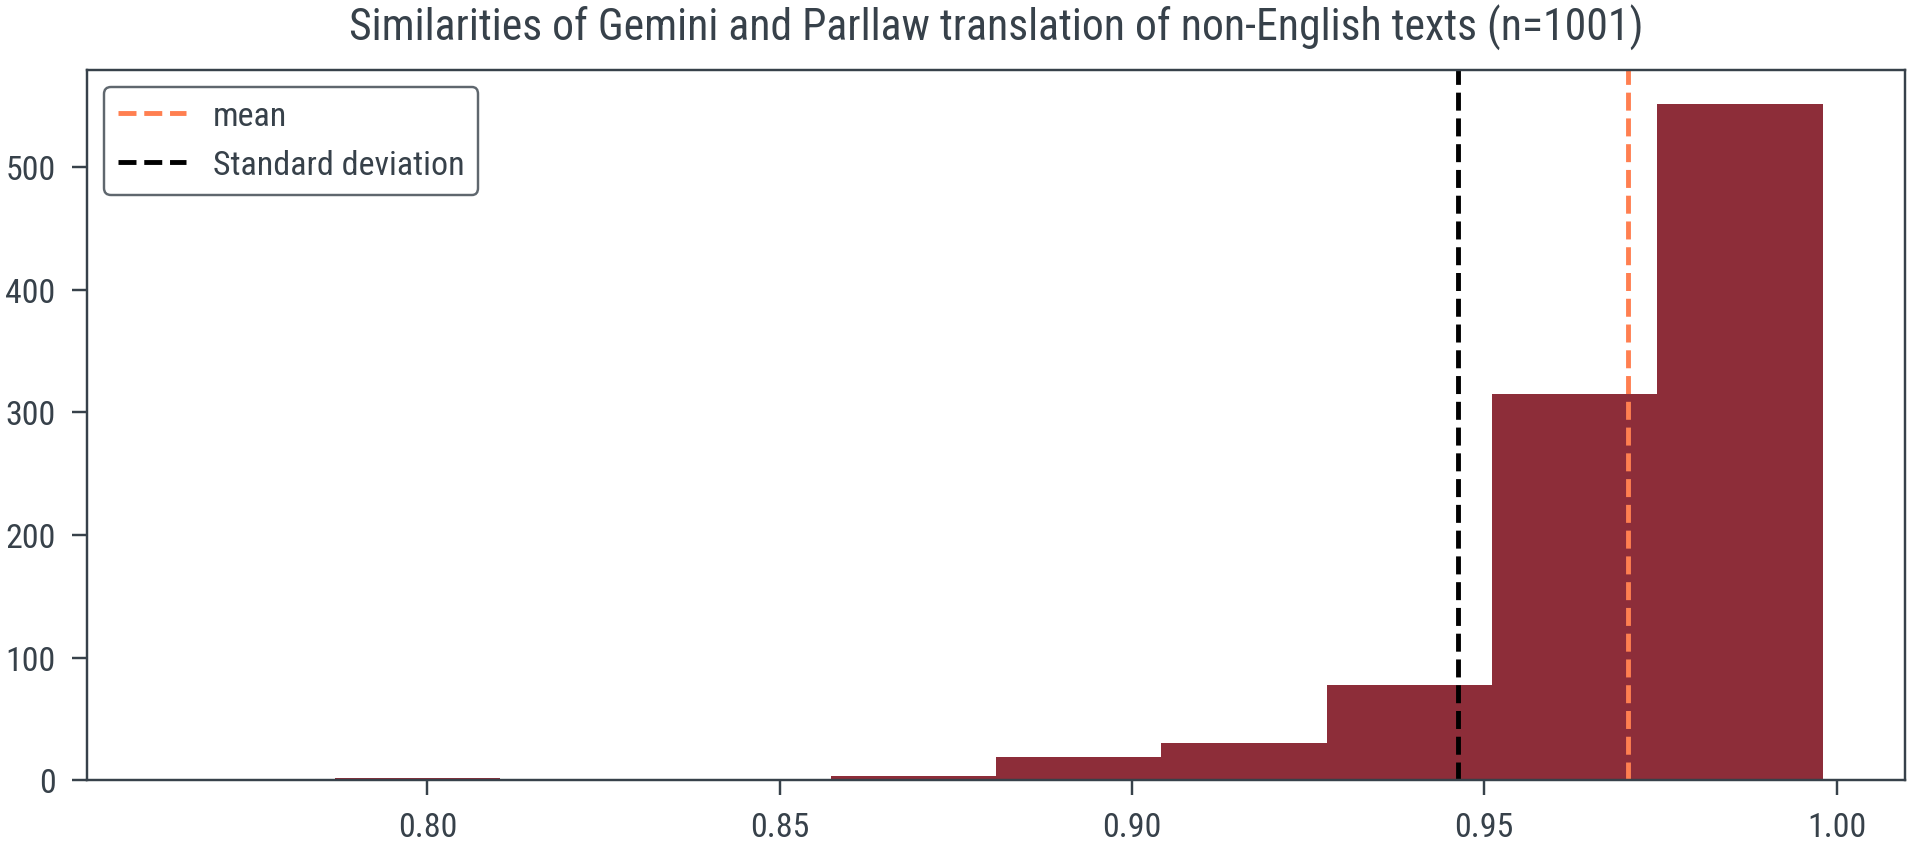

In [46]:
plt.axvline(similarity_non_eng_gm_pl.mean(), c="coral", label="mean", linestyle="--")
plt.axvline(similarity_non_eng_gm_pl.mean() - similarity_non_eng_gm_pl.std(), c="black", label="Standard deviation", linestyle="--")
plt.hist(similarity_non_eng_gm_pl)
plt.title(f"Similarities of Gemini and Parllaw translation of non-English texts (n={len(similarity_non_eng_gm_pl)})")
_ = plt.legend()

To be more confident about our estimate of similarity, compute bootstrap of mean similarity between Parllaw and Gemini translation:

Avg. cosine similarity of gemini and parllaw translation is with prob. 0.95 greater 0.9690 (N: 1001)


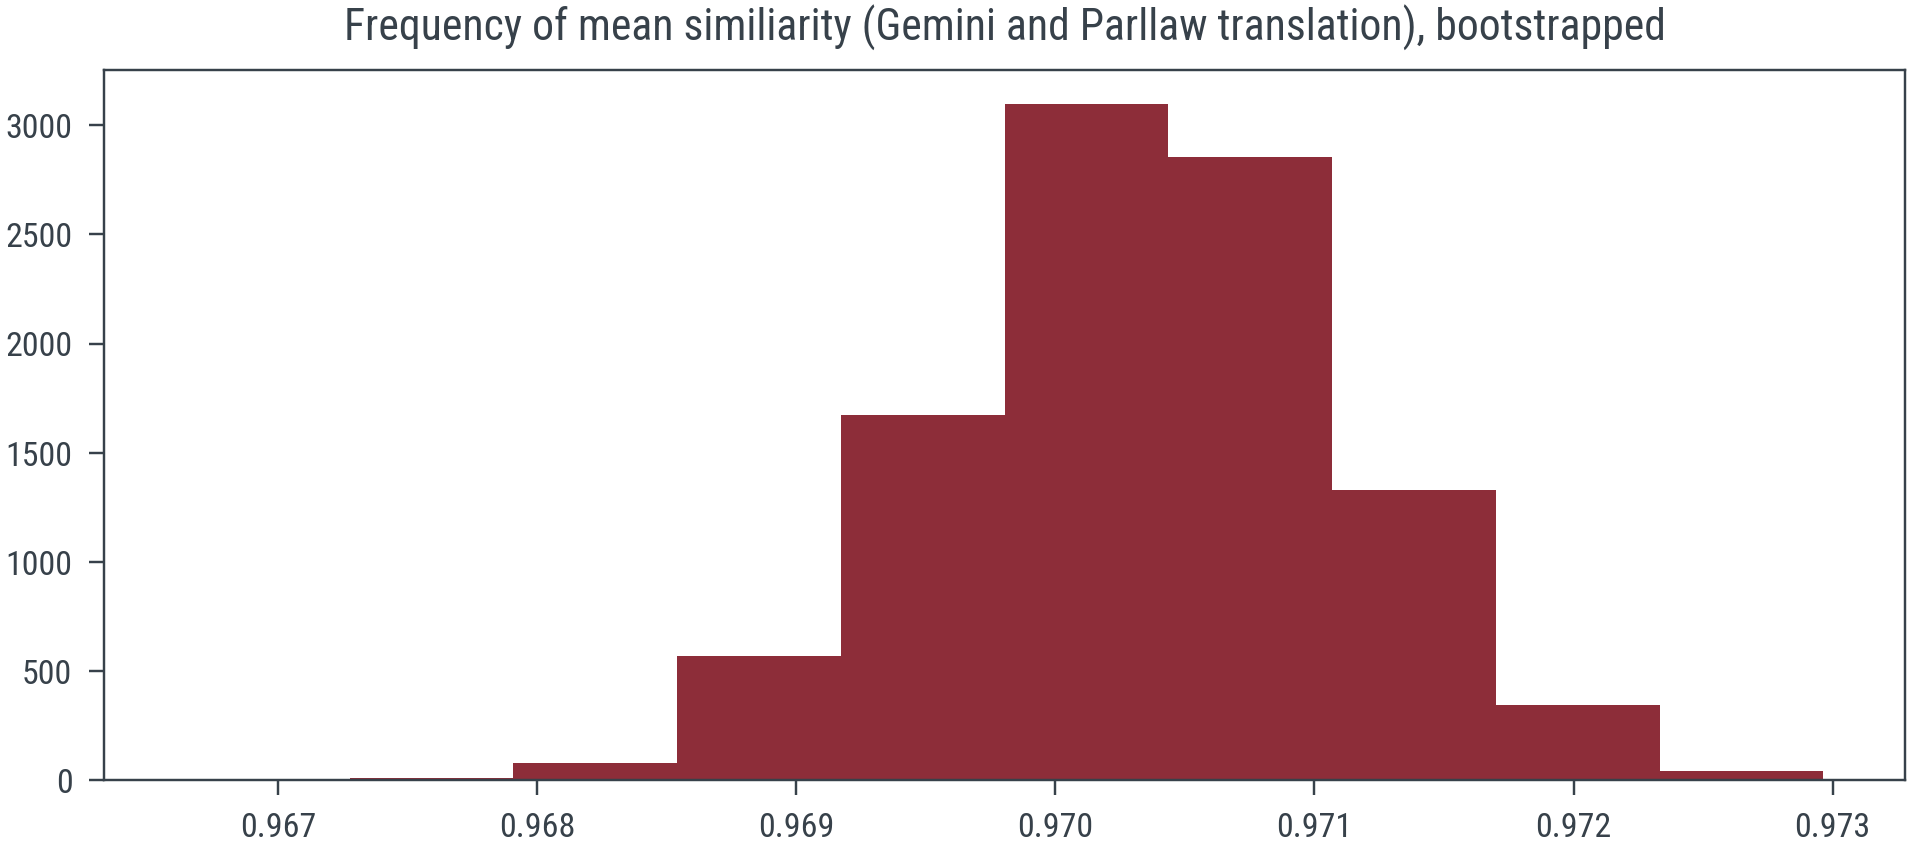

In [47]:
ci = bootstrap((similarity_non_eng_gm_pl,), np.mean, alternative="greater")
plt.hist(ci.bootstrap_distribution)
plt.title("Frequency of mean similiarity (Gemini and Parllaw translation), bootstrapped")
print("Avg. cosine similarity of gemini and parllaw translation is with prob. 0.95 greater", '%.4f' % ci.confidence_interval.low, f"(N: {len(similarity_non_eng_gm_pl)})")


=> We assume with high confidence that: for texts that are not already in English, the similarity of Gemini and Parllaw translation is on average >= 0.969 according to our estimation. 

=> For all further analyses, we assume that this difference is negible so that we can use Gemini to translate the speeches which were not translated by Parllaw 